In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import glob
import json
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
class GreeneryDataset(Dataset):
    def __init__(self, img_dir, transform=None, target_size=(512, 512)):
        self.img_dir = img_dir
        self.transform = transform
        self.target_size = target_size

        self.img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        file_id = os.path.splitext(os.path.basename(img_path))[0]
        json_path = os.path.join(self.img_dir, f"{file_id}.json")

        image = Image.open(img_path).convert('RGB')
        image = image.resize(self.target_size)

        mask = Image.new('L', self.target_size, 0)
        if os.path.exists(json_path):
            with open(json_path) as f:
                data = json.load(f)
                draw = ImageDraw.Draw(mask)
                for shape in data['shapes']:
                    points = shape['points']
                    polygon = [tuple(p) for p in points]
                    draw.polygon(polygon, outline=1, fill=1)

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        mask = transforms.ToTensor()(mask)

        return image, mask

In [21]:
class PSPNetLite(nn.Module):
    def __init__(self, n_classes):
        super(PSPNetLite, self).__init__()

        resnet = models.resnet18(pretrained=True)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.ppm = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(scale),
                nn.Conv2d(512, 128, kernel_size=1),
                nn.ReLU(inplace=True)
            ) for scale in [1, 2, 3, 6]
        ])

        self.final_conv = nn.Sequential(
            nn.Conv2d(512 + 4*128, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, n_classes, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.size()[2:]

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        ppm_outs = [x]
        for ppm in self.ppm:
            ppm_out = ppm(x)
            ppm_out = F.interpolate(ppm_out, size=x.size()[2:], mode='bilinear', align_corners=False)
            ppm_outs.append(ppm_out)

        x = torch.cat(ppm_outs, dim=1)
        x = self.final_conv(x)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

        return x

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = GreeneryDataset(
    img_dir='/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/green_images_Diamond_bar/',
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    target_size=(512, 512)
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

psp_model = PSPNetLite(n_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(psp_model.parameters(), lr=1e-3)

In [23]:
num_epochs = 30

for epoch in range(num_epochs):
    psp_model.train()
    train_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for images, masks in loop:
        images = images.to(device)
        masks = masks.to(device)

        outputs = psp_model(images)

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f'[PSPNet] Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss/len(train_loader):.4f}')

[PSPNet] Epoch [1/30], Loss: 0.0310


[PSPNet] Epoch [2/30], Loss: 0.0006


[PSPNet] Epoch [3/30], Loss: 0.0002


[PSPNet] Epoch [4/30], Loss: 0.0001


[PSPNet] Epoch [5/30], Loss: 0.0001


[PSPNet] Epoch [6/30], Loss: 0.0001


[PSPNet] Epoch [7/30], Loss: 0.0001


[PSPNet] Epoch [8/30], Loss: 0.0001


[PSPNet] Epoch [9/30], Loss: 0.0001


[PSPNet] Epoch [10/30], Loss: 0.0001


[PSPNet] Epoch [11/30], Loss: 0.0001


[PSPNet] Epoch [12/30], Loss: 0.0001


[PSPNet] Epoch [13/30], Loss: 0.0001


[PSPNet] Epoch [14/30], Loss: 0.0001


[PSPNet] Epoch [15/30], Loss: 0.0001


[PSPNet] Epoch [16/30], Loss: 0.0001


[PSPNet] Epoch [17/30], Loss: 0.0001


[PSPNet] Epoch [18/30], Loss: 0.0001


[PSPNet] Epoch [19/30], Loss: 0.0001


[PSPNet] Epoch [20/30], Loss: 0.0001


[PSPNet] Epoch [21/30], Loss: 0.0001


[PSPNet] Epoch [22/30], Loss: 0.0001


[PSPNet] Epoch [23/30], Loss: 0.0001


[PSPNet] Epoch [24/30], Loss: 0.0001


[PSPNet] Epoch [25/30], Loss: 0.0001


[PSPNet] Epoch [26/30], Loss: 0.0001


[PSPNet] Epoch [27/30], Loss: 0.0001


[PSPNet] Epoch [28/30], Loss: 0.0001


[PSPNet] Epoch [29/30], Loss: 0.0001


[PSPNet] Epoch [30/30], Loss: 0.0001


In [24]:
save_path = '/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/models/pspnet_greenery.pth'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(psp_model.state_dict(), save_path)
print(f'PSPNet Model saved to {save_path}')

PSPNet Model saved to /content/drive/MyDrive/MUSA-695/urban_greenery_mapping/models/pspnet_greenery.pth


In [28]:
import torchvision.models as models

class PSPNetLite(nn.Module):
    def __init__(self, n_classes):
        super(PSPNetLite, self).__init__()

        resnet = models.resnet18(pretrained=True)
        self.layer0 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool)
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        self.ppm = nn.ModuleList([
            nn.Sequential(
                nn.AdaptiveAvgPool2d(scale),
                nn.Conv2d(512, 128, kernel_size=1),
                nn.ReLU(inplace=True)
            ) for scale in [1, 2, 3, 6]
        ])

        self.final_conv = nn.Sequential(
            nn.Conv2d(512 + 4*128, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, n_classes, kernel_size=1)
        )

    def forward(self, x):
        input_size = x.size()[2:]

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        ppm_outs = [x]
        for ppm in self.ppm:
            ppm_out = ppm(x)
            ppm_out = F.interpolate(ppm_out, size=x.size()[2:], mode='bilinear', align_corners=False)
            ppm_outs.append(ppm_out)

        x = torch.cat(ppm_outs, dim=1)
        x = self.final_conv(x)
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

        return x

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

psp_model_path = '/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/models/pspnet_greenery.pth'

model = PSPNetLite(n_classes=1).to(device)
model.load_state_dict(torch.load(psp_model_path))
model.eval()

print("Model loaded successfully")

Model loaded successfully


In [34]:
test_dataset = GreeneryDataset(
    img_dir='/content/drive/MyDrive/MUSA-695/urban_greenery_mapping/test_images_Diamond_bar',
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    target_size=(512, 512)
)

test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [36]:
def calculate_accuracy(outputs, masks, threshold=0.5):
    preds = torch.sigmoid(outputs)
    preds = (preds > threshold).float()
    correct = (preds == masks).float()
    acc = correct.sum() / correct.numel()
    return acc

def calculate_iou(outputs, masks, threshold=0.5):
    preds = torch.sigmoid(outputs)
    preds = (preds > threshold).float()

    intersection = (preds * masks).sum()
    union = preds.sum() + masks.sum() - intersection
    if union == 0:
        return torch.tensor(1.0)
    else:
        iou = intersection / union
        return iou

In [37]:
import matplotlib.pyplot as plt

def show_predictions(model, dataloader, num_images=4):
    model.eval()
    images_shown = 0
    plt.figure(figsize=(12, num_images * 4))

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                plt.subplot(num_images, 3, images_shown * 3 + 1)
                plt.imshow(images[i].cpu().permute(1,2,0))
                plt.title('Input Image')
                plt.axis('off')

                plt.subplot(num_images, 3, images_shown * 3 + 2)
                plt.imshow(masks[i][0].cpu(), cmap='gray')
                plt.title('Ground Truth')
                plt.axis('off')

                plt.subplot(num_images, 3, images_shown * 3 + 3)
                plt.imshow(preds[i][0].cpu(), cmap='gray')
                plt.title('Prediction')
                plt.axis('off')

                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

In [38]:
criterion = nn.BCEWithLogitsLoss()

test_loss = 0.0
total_accuracy = 0.0
total_iou = 0.0
num_batches = len(test_loader)

with torch.no_grad():
    with tqdm(test_loader, desc='Evaluating', unit='batch') as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            test_loss += loss.item()

            accuracy = calculate_accuracy(outputs, masks)
            iou = calculate_iou(outputs, masks)

            total_accuracy += accuracy.item()
            total_iou += iou.item()

            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), iou=iou.item())

avg_test_loss = test_loss / num_batches
avg_accuracy = total_accuracy / num_batches
avg_iou = total_iou / num_batches

print(f'\nTest Loss: {avg_test_loss:.4f}')
print(f'Test Accuracy: {avg_accuracy:.4f}')
print(f'Test IoU: {avg_iou:.4f}')

Evaluating: 100%|██████████| 9/9 [00:29<00:00,  3.29s/batch, accuracy=0.999, iou=0, loss=7e-5]


Test Loss: 0.0001
Test Accuracy: 0.9983
Test IoU: 0.0000


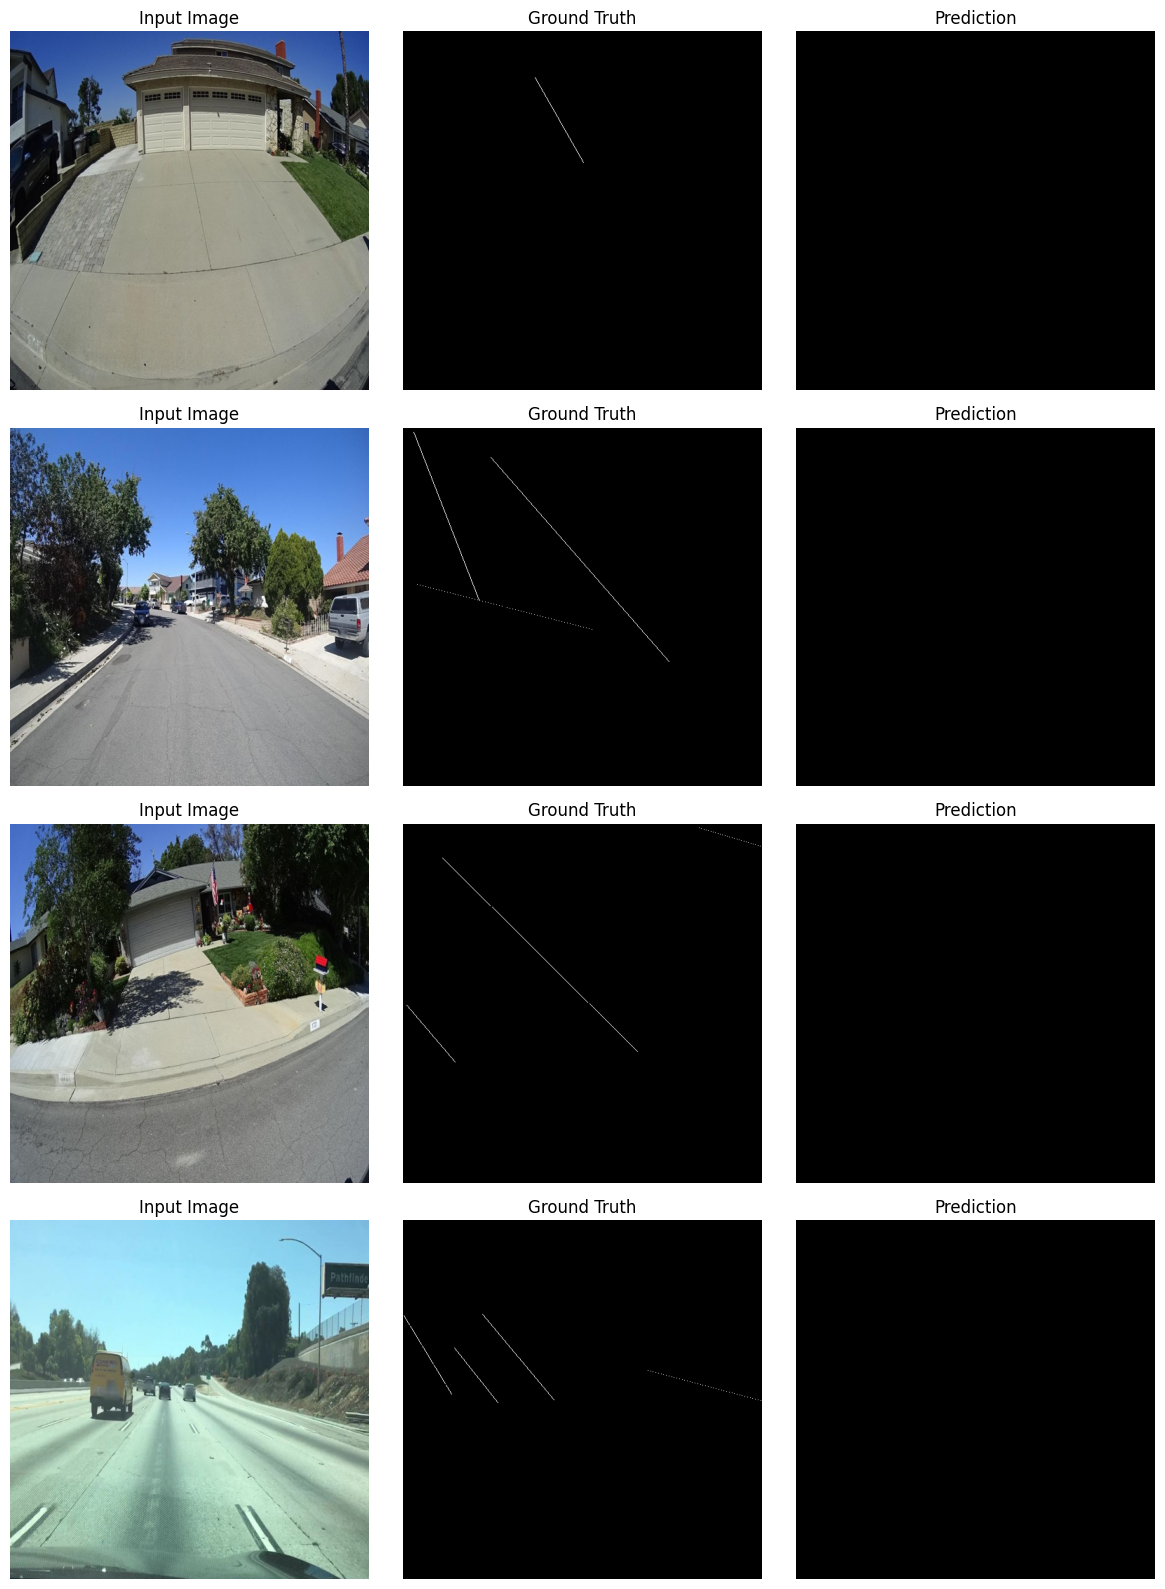

In [39]:
show_predictions(model, test_loader)